<a href="https://colab.research.google.com/github/matthold86/DeepLearningWPython/blob/main/predicting_housing_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Housing Prices

________________________________________________

#### **Summary**

This notebook will walk through an artificial neural network used for regression to predict the median home price in a Boston suburb. The model is trained on 13 parameters of which they are all numerical, but can be continuous, ordinal, or binary. The dataset contains approximately 550 observations.

________________________________________________

#### **Step 0: Install Packages**

#### **Step 1: Establish Google Drive Connection**
This first step mounts the Colab notebook to the `/DeepLearningWPython` directory on my Google Drive. Any data required for this project (data not accessible via link or python package) will be stored in `/DeepLearningWPython` for its convenient integration with Google Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Github/DeepLearningWPython/

/content/drive/MyDrive/Github/DeepLearningWPython


#### **Step 2: Prepare the Data**

In [1]:
from keras.datasets import boston_housing
from keras import models, layers
import numpy as np

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [3]:
# Normalize the values for each parameter around zero
mean_parameters = train_data.mean(axis=0)
std_parameters = train_data.std(axis=0)
train_data = (train_data - mean_parameters)/std_parameters
test_data = (test_data - mean_parameters)/std_parameters

In [4]:
train_data.shape

(404, 13)

#### **Step 3: Prepare the Model**

In [6]:
# Create function for generating the model

# No activation function is requred for final layer because this model will use multiple linear regression to predict a scalar output.
def create_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))

# Loss function: 'MSE' (Mean Squared Error)
# Metrics: 'MAE' (Mean Absolute Error) Units: $Thousands
  model.compile(
      loss='mse',
      optimizer='rmsprop',
      metrics=['mae']
  )
  return model

#### **Step 4: Train the Model**

Because of the smaller dataset, we'll use K-Fold cross-validation to mitigate the effects of having a training dataset that's not representative of the entire dataset. We will use 4 folds and take an average of the validation MAE (mean absolute error) to evaluate the model.



In [13]:
# Prepare data for K-Fold Cross Validation
folds = 4
section_size = train_data.shape[0] // folds
validation_accuracy_scores = []
all_val_mae = []
epochs = 500
batch_size = 1

for i in range(folds):
  val_data = train_data[i*section_size:(i+1)*section_size]
  val_targets = train_targets[i*section_size:(i+1)*section_size]
  training_data = np.concatenate(
      (train_data[:i*section_size],
      train_data[(i+1)*section_size:]),
      axis = 0
  )
  training_targets = np.concatenate(
      (train_targets[:i*section_size],
      train_targets[(i+1)*section_size:]),
      axis = 0
  )
  model = create_model()
  history = model.fit(
      training_data,
      training_targets,
      epochs = epochs,
      batch_size = batch_size,
      validation_data=(val_data, val_targets)
  )
  val_mae_history = history.history['val_mae']
  all_val_mae.append(val_mae_history)
  val_mse, val_mae  = model.evaluate(val_data, val_targets, verbose=0)
  validation_accuracy_scores.append(val_mae)

average_val_mae = np.mean(validation_accuracy_scores)
mae_price = round(average_val_mae*1000, 2)
print(f'The average validation MAE for this prediction model is {average_val_mae}. This model is, on average, ${mae_price} off from the actual house price.')




Epoch 1/500
303/303 [==============================] - 2s 3ms/step - loss: 197.4375 - mae: 10.7329 - val_loss: 43.2850 - val_mae: 4.4111
Epoch 2/500
303/303 [==============================] - 1s 3ms/step - loss: 35.0500 - mae: 4.0470 - val_loss: 27.5320 - val_mae: 3.4413
Epoch 3/500
303/303 [==============================] - 1s 4ms/step - loss: 25.0204 - mae: 3.3241 - val_loss: 22.4316 - val_mae: 3.0775
Epoch 4/500
303/303 [==============================] - 1s 4ms/step - loss: 21.2712 - mae: 3.0206 - val_loss: 20.1652 - val_mae: 2.8263
Epoch 5/500
303/303 [==============================] - 1s 4ms/step - loss: 18.0453 - mae: 2.7485 - val_loss: 17.5621 - val_mae: 2.9010
Epoch 6/500
303/303 [==============================] - 1s 3ms/step - loss: 16.0183 - mae: 2.6769 - val_loss: 15.2151 - val_mae: 2.4996
Epoch 7/500
303/303 [==============================] - 1s 3ms/step - loss: 15.2102 - mae: 2.5448 - val_loss: 13.8888 - val_mae: 2.5417
Epoch 8/500
303/303 [==============================] 

#### **Step 5: Plot the Results**

To determine the appropriate number of epochs for this model, the validation MAE for all 4 k-fold iterations will be averaged, then plotted to find if/when overfitting begins to occur.

In [14]:
# Create list for per-epoch average MAE across all folds
avg_history_mae = [
    np.mean([fold[i] for fold in all_val_mae]) for i in range(epochs)
    ]

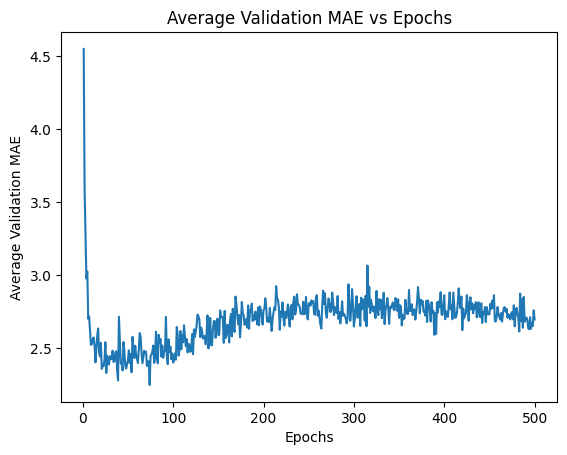

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(avg_history_mae)+1), avg_history_mae)
plt.xlabel('Epochs')
plt.ylabel('Average Validation MAE')
plt.title('Average Validation MAE vs Epochs')

plt.show()

The validation MAE appears to bottom out, but the exact number of epochs is unknown. The moving average is plotted below to dampen the noise. The first 10 epochs will be omitted to narrow the y-axis validation mae range.

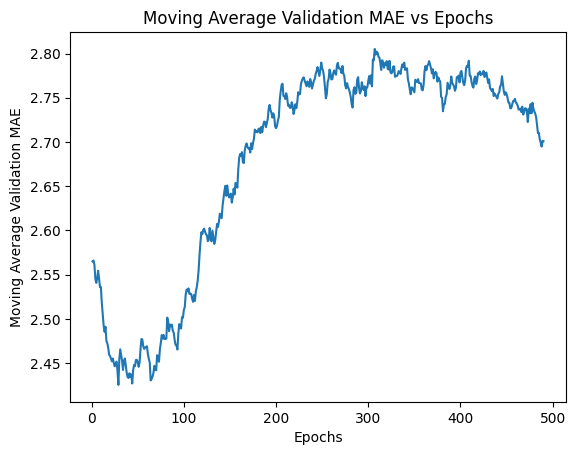

In [17]:
def moving_average(data, factor = 0.9):
  smoothed_data = []
  for dp in data:
    if smoothed_data:
      previous = smoothed_data[-1]
      smoothed_data.append(previous*factor+dp*(1-factor))
    else:
      smoothed_data.append(dp)
  return smoothed_data

moving_average_mae = moving_average(avg_history_mae[10:])

plt.plot(range(1,len(moving_average_mae)+1), moving_average_mae)
plt.xlabel('Epochs')
plt.ylabel('Moving Average Validation MAE')
plt.title('Moving Average Validation MAE vs Epochs')

plt.show()


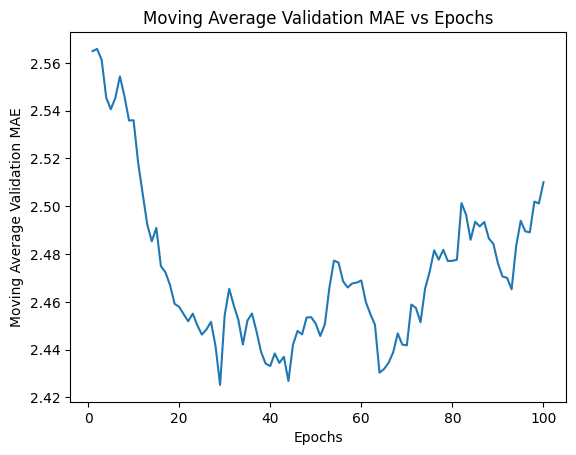

In [18]:
plt.plot(range(1,101), moving_average_mae[0:100])
plt.xlabel('Epochs')
plt.ylabel('Moving Average Validation MAE')
plt.title('Moving Average Validation MAE vs Epochs')

plt.show()

The moving aveage validation mae appears to reach a minimum around 40 epochs before starting to rise. Therefore, this model should be run for no more than 40 epochs to prevent overfitting on the training data.

This is the conclusion of a feed-forward artificial neural network used for regression. This network uses a linear activation function to predict a continuous output (house price). Mean absolute error is used to evaluate the model performance. K-Fold cross validation was used due to the limited data. When trained for 500 epochs, the model was, on average, $2697.33 off from the actual housing price. To prevent overfitting it is recommended that this model only be trained for 40 epochs as the validation MAE reached an approximate minimum after 40 epochs.